In [1]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

DATA_PATH_TRAIN = '../bds/treino.csv'


In [2]:
treino = pd.read_csv(DATA_PATH_TRAIN, sep=',')

In [3]:
import pmdarima as pm
from pmdarima import model_selection
class TimeSeries():
    def __init__(self, nome, dataframe):
        self.nome = nome
        self.dataframe = dataframe
        self.serie = None
        self.train = None
        self.validation = None
        self.models = {}
        self.predictions = {}
    
    def set_models(self, name = None, model = None):
        """
        Adiciona um modelo ao dicionário de séries.

        :param name: Nome do modelo.
        :param model: Modelo.
        :raises ValueError: Se o nome ou o modelo forem None.
        """
        try:
            if name is None or model is None:
                raise ValueError("O nome e o modelo não podem ser None.")
            
            self.models[name] = model

        except ValueError as e:
            print(f"Erro: {e}")
            

    def get_model(self, name):
        """
        Retorna um modelo que está na série.

        :param name: Nome do modelo.
        :return dataframe: modelo.
        """
        try:
            if name not in self.models:
                raise ValueError("O modelo não está no dicionário")
            
            return self.models[name]

        except ValueError as e:
            print(f"Erro: {e}")
    
    def get_names_models(self):
        if self.models is not None:
            return list(self.models.keys())
        return None
    
    def print_names_models(self):
        print(self.get_names_models())

    def get_train_validation(self):
        self.train, self.validation =  model_selection.train_test_split(np.array(self.dataframe['Close'].values), train_size=0.8)

    def get_train(self):
        return self.train
    
    def get_validation(self):
        return self.validation
    
    def fit_model(self, name_model = None):
        try:
            if name_model not in self.models:
                    raise ValueError("O modelo não está no dicionário")
            
            self.models[name_model].fit(self.train)

        except ValueError as e:
            print(f"Erro: {e}")
    
    def predict_model(self, name_model, quantidade_pred = None):
        try:
            if name_model not in self.models:
                    raise ValueError("O modelo não está no dicionário")
            
            if quantidade_pred is None:
                quantidade_pred = len(self.validation)
            self.predictions[name_model] = list(self.models[name_model].predict(n_periods = int(quantidade_pred)))

        except ValueError as e:
            print(f"Erro: {e}")
    
    def get_predictions(self,name_model):
        return self.predictions[name_model]
    
    def get_plot_serie(self, previsao=None, name_model=None):
        plt.figure(figsize=(12, 6))
        
        # Plotando a série temporal real
        plt.plot(self.dataframe["Date"], self.dataframe['Close'], label='Real')
        
        if previsao:
            # Verificando se a predição existe
            if name_model in self.predictions:
                # Concatenando os dados de treino com as predições
                combined_values = np.concatenate([self.train, self.predictions[name_model]])
                
                # Plotando os valores combinados
                plt.plot(self.dataframe["Date"][:len(combined_values)], combined_values, 
                        label='Previsão', linestyle='--', marker='*')
                
                # Adicionando uma linha vertical para indicar o fim do treino
                plt.axvline(x=self.dataframe["Date"].iloc[len(self.train)-1], color='green', linestyle='--', label='Fim do treino')
            else:
                raise ValueError("Modelo não possui predições para plotar.")
        
        # Configurações do gráfico
        plt.title(f'Gráfico da série temporal - {self.nome}')
        plt.xlabel('Data')
        plt.ylabel('Close')
        plt.legend()
        plt.grid(False)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
        
        
            


In [4]:
ts_tesla = TimeSeries("Valor de Fechamento das Ações da Tesla", treino)

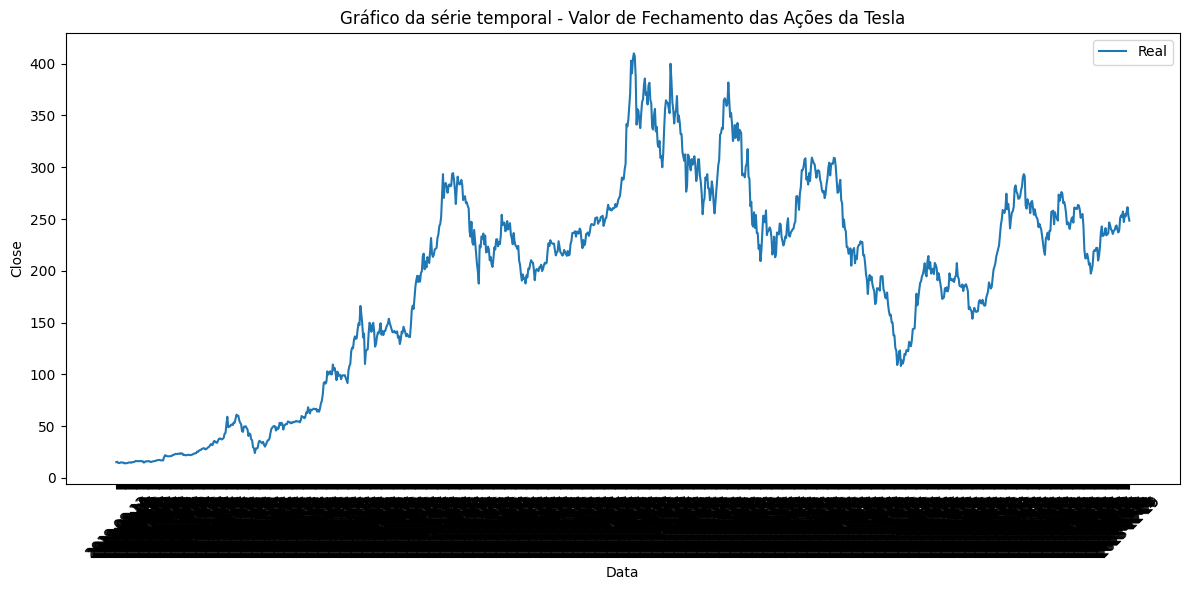

In [5]:
ts_tesla.get_plot_serie()

In [6]:
ts_tesla.get_train_validation()

In [7]:
modelo_1 = pm.ARIMA(order=(1,0,1))
modelo_2 =  pm.ARIMA(order=(2,0,1))
modelo_3 = pm.ARIMA(order=(1,0,0))

models = {
    "Arima (1,0,1)": modelo_1,
    "Arima (2,0,1)": modelo_2,
    "Arima (1,0,0)": modelo_3
}



In [8]:
def janela_deslizante(models):    
    cv_scores = {}
    averages_erro = {}
    cv = model_selection.SlidingWindowForecastCV(window_size=100, step=10, h=1)
    for name in models.keys():
        cv_scores[name] = model_selection.cross_val_score(
            models[name], ts_tesla.get_train(), scoring='smape', cv=cv)
        
    for name in cv_scores.keys():
        print(f'Scores (CV) modelo {name}: {cv_scores[name].tolist()}')
        averages_erro[name] = np.average(cv_scores[name])



    best_model_index = np.argmin(averages_erro.values)


    for name in averages_erro.keys():
        print(f"Média do SMAPE > {averages_erro[name]} do modelo > {models[name]}")

    best_model = list(models.values())[0]
    best_model_name = {list(models.keys())[best_model_index]}
    best_model_name = sorted(best_model_name)
    best_model_name = ''.join(best_model_name)

    print(f'Melhor modelo {best_model_name}')

    return best_model, best_model_name

In [9]:
best_model, best_model_name = janela_deslizante(models)

Scores (CV) modelo Arima (1,0,1): [2.6572944150411346, 0.4669501990977448, 18.51678137950024, 7.270808418784476, 0.607311127387768, 1.0063643935660993, 4.570811738895427, 2.6535948871247594, 5.2847024025516935, 1.4145854322848523, 0.9124194868152924, 4.727178541493327, 2.9575535233261463, 10.318723729631039, 6.278617802346698, 2.321659741531846, 2.396013738339203, 3.3394024504424302, 2.204131342913121, 2.6247461092311593, 1.7639734012876187, 3.25902756015706, 0.2556180704433934, 3.74222626725931, 0.5611499507074508, 4.574425245896552, 0.842386521744589, 5.364112033036716, 0.7387656421279187, 6.304533311068175, 2.2074625667234273, 1.3969719158001688, 8.736933365643237, 4.246500454171451, 3.281299699812743, 0.5790506646726282, 1.3623433970010848, 4.712905926429327, 0.6370902104067778, 1.013206168632764, 1.012203091576306, 1.8387390068878853, 0.027608912845803853, 0.6736642540045764, 0.22889835268211542, 3.1207761265467773, 3.1572807322157335, 2.5677052142936705, 5.480730741642835, 4.9490

In [10]:
ts_tesla.set_models(name=best_model_name,model=best_model)

In [11]:
ts_tesla.fit_model(name_model=best_model_name)
ts_tesla.predict_model(name_model=best_model_name)

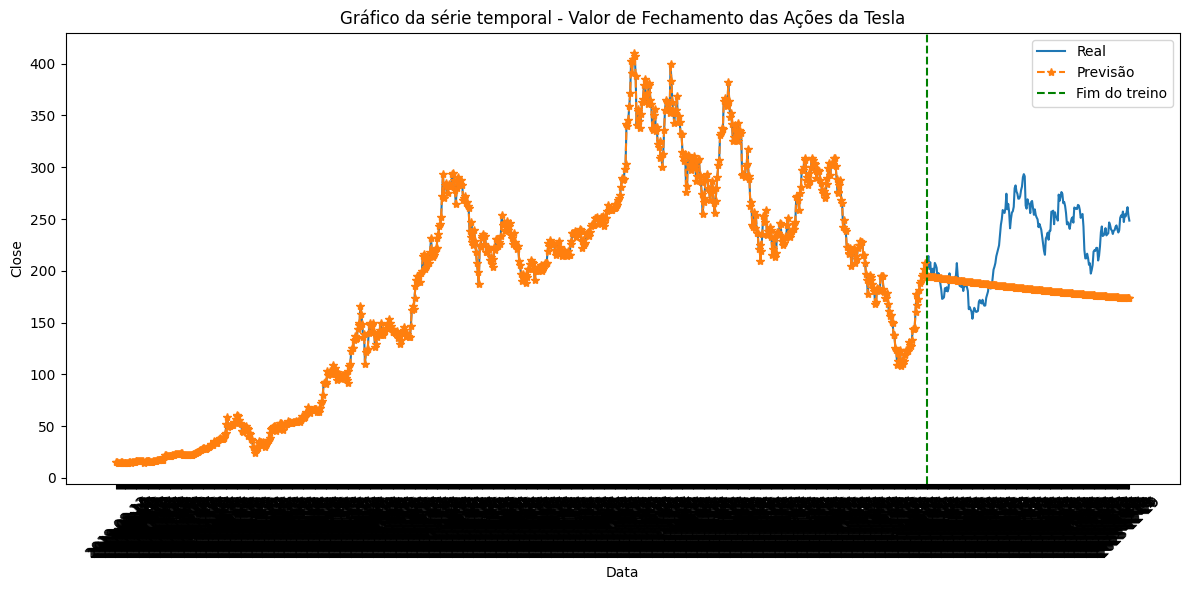

In [12]:
ts_tesla.get_plot_serie(previsao=True, name_model=best_model_name)